We want to check the variation of floquet quasi energy vs $(4h/\omega)$.
So there are two options here, either we can change the frequency or we can change the symmetry breaking field's amplitude. 
We will do both of the options.

# 1. when frequency varies

time taken 19.603511810302734 sec


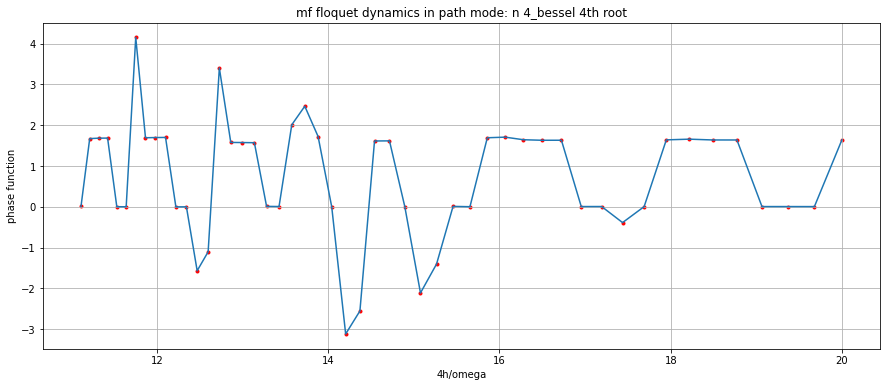

In [29]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time
from array import *

start = time.time()

    
N = 4
h = 25.0
h0 = 0.1
nn = 1   # this is the 'th column of the inital floquet evolution matrix 
         # for which the path we shall follow
tsteps = 10
q = np.linspace(-0.5, 0.5, N)
omega_range = np.linspace(5.0,9.0,50)
omegas = omega_range
#omegas = np.hstack((omega_range,41.5831))   # inlcude the frequency coresponidng to Bessel's root
omegas.sort()                               # arrange the omegas in ascendng order

psi = np.eye(N) + (1j) * np.zeros((N,N))
cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(omegas))
prob = np.zeros(N)

title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 4th root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel4.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp, N):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp,N):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp, N), periodic_psi)

if __name__ == '__main__':
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
    
    # calculate for first frequency
    w = omegas[0]
    T = 2 * np.pi/w                            
    t = np.linspace(0,2 * np.pi/w,tsteps)           
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,N), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[N-1]/np.linalg.norm(psi_t[N-1])
    
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals[nn]))/T
    evecs_path = evecs[nn]
    phasefunc_path[0] = phasefunc.real
    
    # calculate for rest of the frequencies
    for cc, w in enumerate(omegas[1:len(omegas)]):
        T = 2 * np.pi/w                      
        t = np.linspace(0,2 * np.pi/w,tsteps)    
        floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))        
        
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]       
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,N), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1]/np.linalg.norm(psi_t[N-1])
        evals, evecs = eig(floqEvolution_mat)
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs))) 
        #print('prob',prob.real)
        
        for i,pr in enumerate(prob):
            if (pr.real >= .9):
                pp = i
                break
        evecs_path = evecs[pp]
        phasefunc = (1j * np.log(evals[pp]))/T
        phasefunc_path[cc+1] = phasefunc.real
                
    print('time taken',time.time()-start,'sec')
    plt.figure(figsize=(15,6))
    plt.title(title)
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.plot(4*h/(omegas),phasefunc_path)
    plt.scatter(4*h/(omegas),phasefunc_path,marker='.',color='r')
    plt.grid()
    #plt.savefig(photoname,dpi = 300)
    plt.show()  

# 2. when h varies

time taken 22.35768222808838 sec


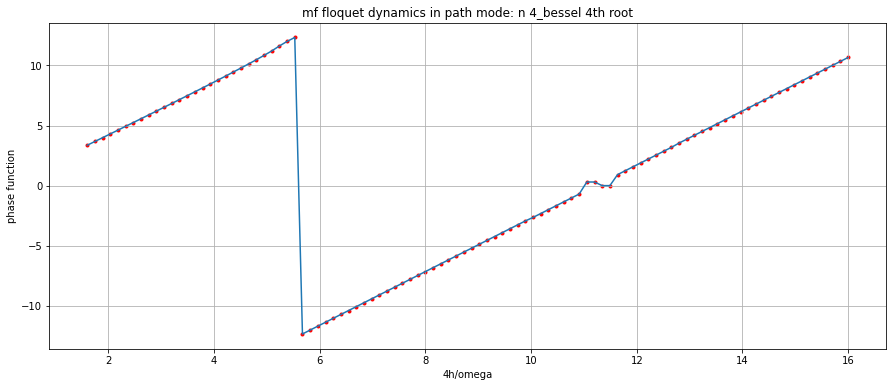

In [26]:
import numpy as np
from odeintw import odeintw
import matplotlib.pyplot as plt
from numpy.linalg import multi_dot, norm, eig
import math
import time
from array import *

start = time.time()

    
N = 4

h0 = 0.1
nn = 1   # this is the 'th column of the inital floquet evolution matrix 
pp = nn  # for which the path we shall follow
tsteps = 50
q = np.linspace(-0.5, 0.5, N)
w = 25.0  # omega frequency
T = 2 * np.pi/w                            
t = np.linspace(0,2 * np.pi/w,tsteps)   
hs = np.linspace(10.0,100.0,100)

psi = np.eye(N) + (1j) * np.zeros((N,N))
cosp = np.zeros((N,N)) + (1j) * np.zeros((N,N))
phasefunc_path = np.zeros(len(hs))
prob = np.zeros(N)

title = "mf floquet dynamics in path mode: n " + str(N) + "_bessel 4th root"
photoname = "n_" + str(N) + "_mfd_bessel_floquet_path_bessel4.jpeg"
filename = "n_" + str(N) + "_mfd.txt"

class Periodic_Lattice(np.ndarray):
    def __new__(cls, input_array, lattice_spacing=None):
        obj = np.asarray(input_array).view(cls)
        obj.lattice_shape = input_array.shape
        obj.lattice_dim = len(input_array.shape)
        obj.lattice_spacing = lattice_spacing
        return obj
    
    def __getitem__(self, index):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__getitem__(index)
    
    def __setitem__(self, index, item):
        index = self.latticeWrapIdx(index)
        return super(Periodic_Lattice, self).__setitem__(index, item)
    
    def __array_finalize__(self, obj):
        if obj is None: return
        self.lattice_shape = getattr(obj, 'lattice_shape', obj.shape)
        self.lattice_dim = getattr(obj, 'lattice_dim', len(obj.shape))
        self.lattice_spacing = getattr(obj, 'lattice_spacing', None)
        pass
    
    def latticeWrapIdx(self, index):
        if not hasattr(index, '__iter__'): return index         # handle integer slices
        if len(index) != len(self.lattice_shape): return index  # must reference a scalar
        if any(type(i) == slice for i in index): return index   # slices not supported
        if len(index) == len(self.lattice_shape):               # periodic indexing of scalars
            mod_index = tuple(( (i%s + s)%s for i,s in zip(index, self.lattice_shape)))
            return mod_index
        raise ValueError('Unexpected index: {}'.format(index))


def floq_jac(periodic_psi,t, h, h0, w, cosp, N):
    drive = h0 + h * np.cos(w * t)
    jac = (1j) * N * (-2.0 * q * q - drive * np.sqrt(1.0 - 4.0 * q *q) * cosp)
    return jac

def floq_func(periodic_psi,t,h,h0,w,cosp,N):
    return np.dot(floq_jac(periodic_psi,t, h0, h, w, cosp, N), periodic_psi)

if __name__ == '__main__':
    periodic_psi  = Periodic_Lattice(psi)       
    cospinit = 0.0
    for k in np.arange(N):
        for m in np.arange(N):
            for l in np.arange(N+1):
                for j in np.arange(l+1):
                    cospinit = cospinit + np.array([pow((-1),(l+j))/math.factorial(2 * l)* \
                                          math.comb(l,j)* periodic_psi[(k+(l-j),(m))]])
            cosp[k,m] = cospinit
            cospinit = 0.0
    
    # calculate for first h
    h = hs[0]        
    floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))
    
    for mm in np.arange(N):
        psi0 = periodic_psi[mm]       
        psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,N), Dfun=floq_jac)
        floqEvolution_mat[mm] = psi_t[N-1]/np.linalg.norm(psi_t[N-1])
    
    evals, evecs = eig(floqEvolution_mat)
    phasefunc = (1j * np.log(evals[nn]))/T
    evecs_path = evecs[nn]
    phasefunc_path[0] = phasefunc.real
    
    # calculate for rest of h
    for cc, h in enumerate(hs[1:len(hs)]):
        floqEvolution_mat = np.zeros((N,N)) + (1j) * np.zeros((N,N))        
        
        for mm in np.arange(N):
            psi0 = periodic_psi[mm]       
            psi_t = odeintw(floq_func,psi0,t,args=(h,h0,w,cosp,N), Dfun=floq_jac)
            floqEvolution_mat[mm] = psi_t[N-1]/np.linalg.norm(psi_t[N-1])
        evals, evecs = eig(floqEvolution_mat)
        prob = np.asarray(list(map(lambda x:np.dot(np.conjugate(evecs_path).T,x),evecs))) 
        #print('prob',prob.real)
        
        for i,pr in enumerate(prob):
            if (pr.real >= .9):
                pp = i
                break
        evecs_path = evecs[pp]
        phasefunc = (1j * np.log(evals[pp]))/T
        phasefunc_path[cc+1] = phasefunc.real
                
    print('time taken',time.time()-start,'sec')
    plt.figure(figsize=(15,6))
    plt.title(title)
    plt.xlabel("4h/omega")
    plt.ylabel("phase function")
    plt.plot(4*hs/w,phasefunc_path)
    plt.scatter(4*hs/w,phasefunc_path,marker='.',color='r')
    plt.grid()
    #plt.savefig(photoname,dpi = 300)
    plt.show()  